Multi-Student Verification System Analyzer Ready
Loading results from all_results.json...
Analyzing data for 1 student(s) and 4 member(s)
Analysis saved as 'invalid_verification_analysis_1students_20250901_232517.png'


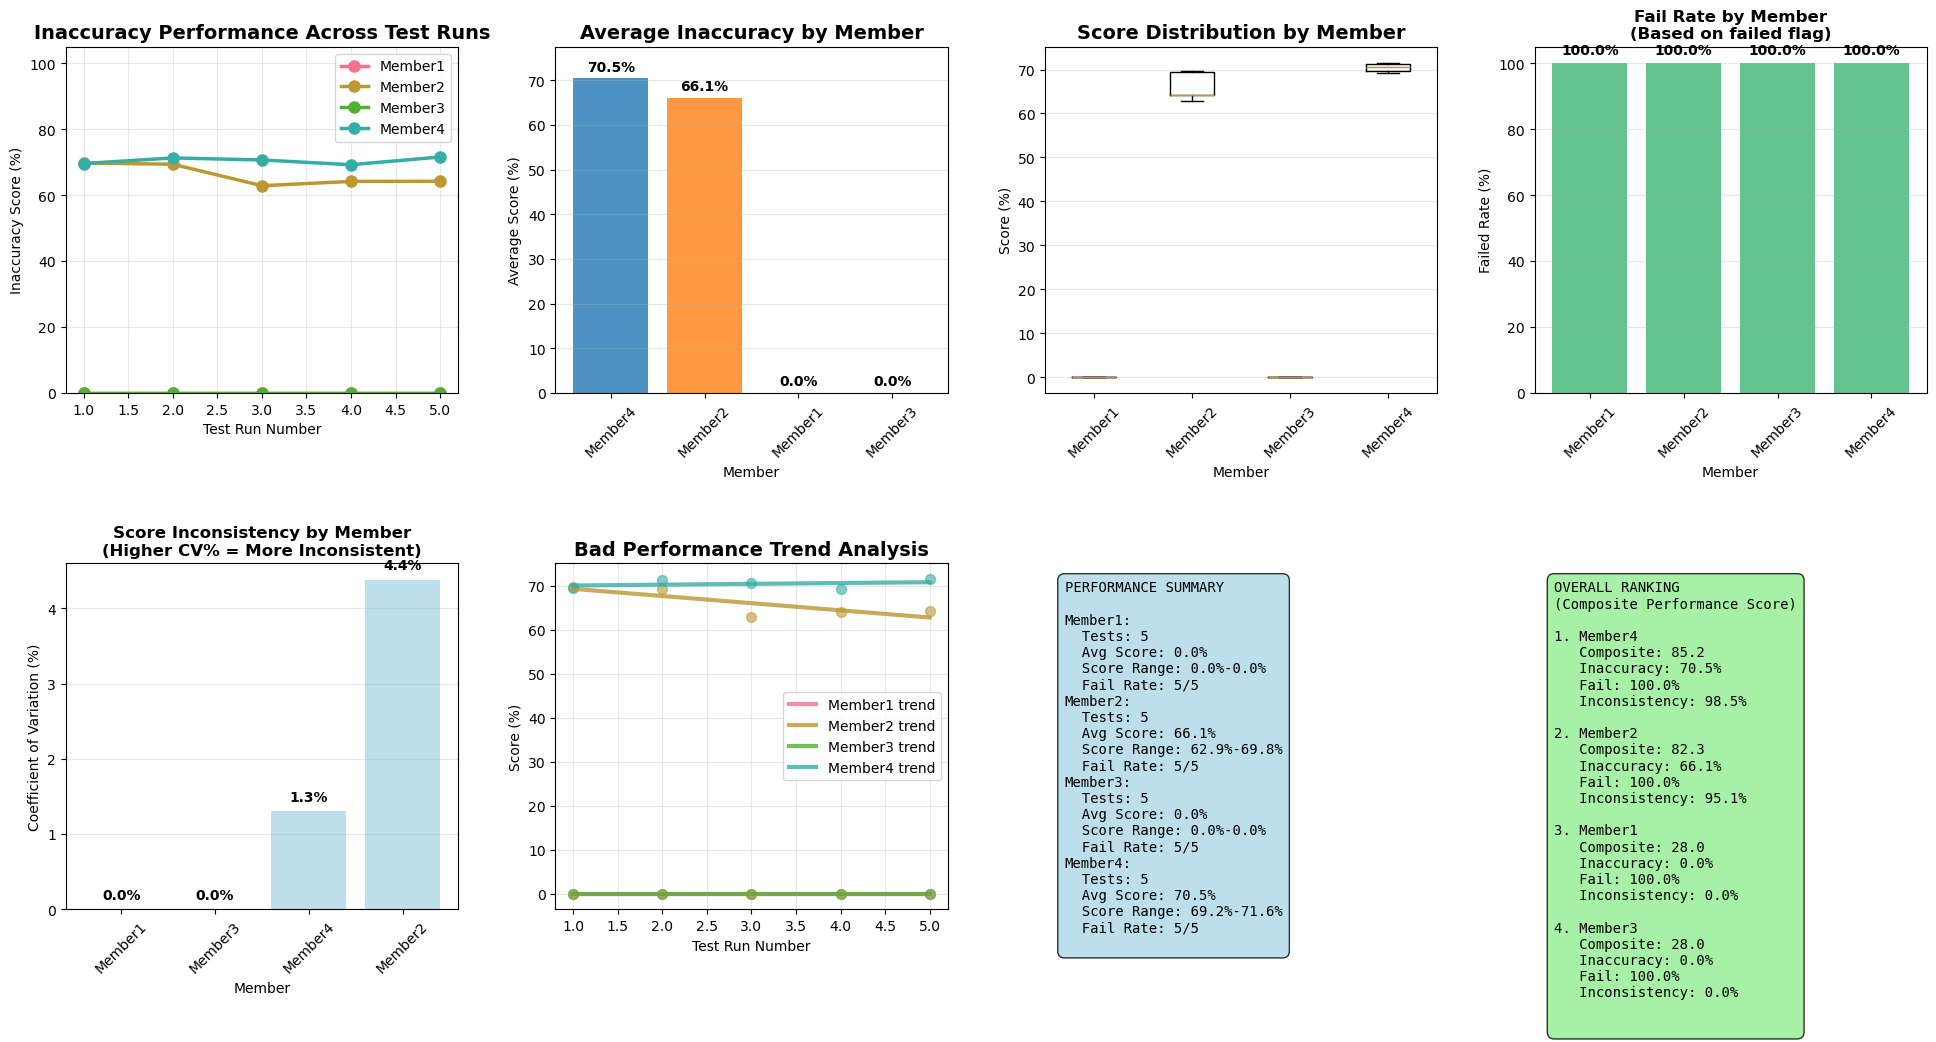

VERIFICATION SYSTEM ANALYSIS REPORT

DATASET OVERVIEW:
  Total Test Runs: 20
  Number of Members: 4
  Number of Students: 1
  Students Tested: S001
  Data Collection Period: 2025-09-01 22:34 to 2025-09-01 22:59

SYSTEM-WIDE PERFORMANCE:
  Average Inaccuracy: 34.14% (±35.10%)
  Overall Fail Rate: 100.0%
  Best Single Performance: 71.6%

MEMBER PERFORMANCE ANALYSIS:
--------------------------------------------------

Member1:
  Test Runs: 5
  Average Score: 0.00% (±0.00%)
  Score Range: 0.0% - 0.0%
  Fail Rate: 5/5 (100.0%)
  Consistency: Low (CV: nan%)

Member2:
  Test Runs: 5
  Average Score: 66.09% (±3.24%)
  Score Range: 62.9% - 69.8%
  Fail Rate: 5/5 (100.0%)
  Consistency: High (CV: 4.9%)

Member3:
  Test Runs: 5
  Average Score: 0.00% (±0.00%)
  Score Range: 0.0% - 0.0%
  Fail Rate: 5/5 (100.0%)
  Consistency: Low (CV: nan%)

Member4:
  Test Runs: 5
  Average Score: 70.48% (±1.03%)
  Score Range: 69.2% - 71.6%
  Fail Rate: 5/5 (100.0%)
  Consistency: High (CV: 1.5%)

KEY INSIGHTS:

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import numpy as np
from pathlib import Path
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


class InvalidResultsAnalyzer:
    """
    Improved analyzer for multi-member verification system results.
    """
    
    def __init__(self, results_directory: str = "results"):
        self.results_dir = Path(results_directory)
        self.results_file = self.results_dir / "all_results.json"
    
    def ensure_file_exists(self):
        """Ensure the results file exists"""
        if not self.results_file.exists():
            raise FileNotFoundError(f"Results file not found at {self.results_file}")
    
    def load_results_dataframe(self, data: list = None) -> pd.DataFrame:
        """Load results from file or provided data into a comprehensive DataFrame"""
        if data is not None:
            df = pd.DataFrame(data)
        else:
            self.ensure_file_exists()
            try:
                with open(self.results_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
            except Exception as e:
                print(f"Error loading results: {e}")
                return pd.DataFrame()
        
        # Data preprocessing
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['score_percentage'] = df['score'] * 100
        return df
    
    def generate_invalid_analysis(self, data: list = None, save_plots: bool = True):
        """
        Generate comprehensive analysis supporting both single and multi-student scenarios.
        """
        df = self.load_results_dataframe(data)
        
        if df.empty:
            print("No data available for analysis!")
            return
        
        # Set plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # Determine analysis scope
        num_students = df['student_id'].nunique()
        num_members = df['member'].nunique()
        
        print(f"Analyzing data for {num_students} student(s) and {num_members} member(s)")
        
        # Create adaptive figure layout
        if num_students == 1:
            fig = plt.figure(figsize=(20, 15))
            self._create_single_student_analysis(df, fig)
        else:
            fig = plt.figure(figsize=(24, 18))
            self._create_multi_student_analysis(df, fig)
        
        plt.tight_layout(pad=3.0)
        
        if save_plots:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'invalid_verification_analysis_{num_students}students_{timestamp}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Analysis saved as '{filename}'")
        
        plt.show()
        return df
    
    def _create_single_student_analysis(self, df, fig):
        """Create plots optimized for single student analysis"""
        
        # 1. Inaccuracy Performance Over Test Runs
        plt.subplot(3, 4, 1)
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member].sort_values('test_run')
            plt.plot(member_data['test_run'], member_data['score_percentage'], 
                    marker='o', linewidth=2.5, label=member, markersize=8)
        
        plt.title('Inaccuracy Performance Across Test Runs', fontsize=14, fontweight='bold')
        plt.xlabel('Test Run Number')
        plt.ylabel('Inaccuracy Score (%)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.ylim(0, 105)
        
        # 2. Average Performance Comparison
        plt.subplot(3, 4, 2)
        avg_scores = df.groupby('member')['score_percentage'].mean().sort_values(ascending=False)
        
        bars = plt.bar(range(len(avg_scores)), avg_scores.values, 
                      alpha=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(avg_scores)])
        plt.title('Average Inaccuracy by Member', fontsize=14, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Average Score (%)')
        plt.xticks(range(len(avg_scores)), avg_scores.index, rotation=45)
        
        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, avg_scores.values)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        plt.ylim(0, max(avg_scores.values) * 1.1)
        
        # 3. Score Distribution Box Plot
        plt.subplot(3, 4, 3)
        member_scores = [df[df['member'] == member]['score_percentage'].values 
                        for member in sorted(df['member'].unique())]
        plt.boxplot(member_scores, labels=sorted(df['member'].unique()))
        plt.title('Score Distribution by Member', fontsize=14, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Score (%)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        
        # 4. Fail Rate Analysis
        plt.subplot(3, 4, 4)
        fail_rates = df.groupby('member').apply(
            lambda x: (x['success'] == False).sum() / len(x) * 100
        ).sort_values(ascending=False)
        
        bars = plt.bar(range(len(fail_rates)), fail_rates.values, 
                      alpha=0.8, color='mediumseagreen')
        plt.title(f'Fail Rate by Member\n(Based on failed flag)', fontsize=12, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Failed Rate (%)')
        plt.xticks(range(len(fail_rates)), fail_rates.index, rotation=45)
        
        for i, (bar, rate) in enumerate(zip(bars, fail_rates.values)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        plt.ylim(0, 105)
        
        # 5. Inconsistency Analysis
        plt.subplot(3, 4, 5)
        consistency_stats = df.groupby('member').agg({
            'score_percentage': lambda x: (np.std(x) / np.mean(x)) * 100 if np.mean(x) > 0 else 0
        })['score_percentage'].sort_values()
        
        bars = plt.bar(range(len(consistency_stats)), consistency_stats.values, 
                      alpha=0.8, color='lightblue')
        plt.title('Score Inconsistency by Member\n(Higher CV% = More Inconsistent)', 
                 fontsize=12, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Coefficient of Variation (%)')
        plt.xticks(range(len(consistency_stats)), consistency_stats.index, rotation=45)
        
        for i, (bar, value) in enumerate(zip(bars, consistency_stats.values)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.096,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 6. Bad Performance Trends (if enough data)
        plt.subplot(3, 4, 6)
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member].sort_values('test_run')
            if len(member_data) >= 3:
                # Calculate trend
                z = np.polyfit(member_data['test_run'], member_data['score_percentage'], 1)
                p = np.poly1d(z)
                plt.plot(member_data['test_run'], p(member_data['test_run']), 
                        linewidth=3, label=f'{member} trend', alpha=0.8)
                plt.scatter(member_data['test_run'], member_data['score_percentage'], 
                           alpha=0.6, s=50)
        
        plt.title('Bad Performance Trend Analysis', fontsize=14, fontweight='bold')
        plt.xlabel('Test Run Number')
        plt.ylabel('Score (%)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # 7. Statistical Summary Table
        plt.subplot(3, 4, 7)
        plt.axis('off')
        
        table_text = "BAD PERFORMANCE SUMMARY\n\n"
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member]
            table_text += f"{member}:\n"
            table_text += f"  Tests: {len(member_data)}\n"
            table_text += f"  Avg Score: {member_data['score_percentage'].mean():.1f}%\n"
            table_text += f"  Score Range: {member_data['score_percentage'].min():.1f}%-{member_data['score_percentage'].max():.1f}%\n"
            table_text += f"  Fail Rate: {(member_data['success'] == False).sum()}/{len(member_data)}\n"
        
        plt.text(0.05, 0.95, table_text, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
                family='monospace')
        
        # 8. Member Ranking
        plt.subplot(3, 4, 8)
        plt.axis('off')
        
        # Calculate composite bad performance score
        member_rankings = []
        for member in df['member'].unique():
            member_data = df[df['member'] == member]
            avg_score = member_data['score_percentage'].mean()
            fail_rate = (member_data['success'] == False).mean() * 100
            inconsistency = 100 - ((member_data['score_percentage'].std() / avg_score) * 100) if avg_score > 0 else 0
            
            # Composite score (weighted: 49% inaccuracy, 28% fail rate, 23% inconsistency)
            composite = (avg_score * 0.49) + (fail_rate * 0.28) + (inconsistency * 0.23)
            
            member_rankings.append({
                'member': member,
                'composite_score': composite,
                'avg_score': avg_score,
                'fail_rate': fail_rate,
                'inconsistency': inconsistency
            })
        
        # Sort by composite score
        member_rankings.sort(key=lambda x: x['composite_score'], reverse=True)
        
        ranking_text = "OVERALL RANKING\n(Composite Bad Performance Score)\n\n"
        for i, perf in enumerate(member_rankings, 1):
            ranking_text += f"{i}. {perf['member']}\n"
            ranking_text += f"   Composite: {perf['composite_score']:.1f}\n"
            ranking_text += f"   Inaccuracy: {perf['avg_score']:.1f}%\n"
            ranking_text += f"   Fail: {perf['fail_rate']:.1f}%\n"
            ranking_text += f"   Inconsistency: {perf['inconsistency']:.1f}%\n\n"
        
        plt.text(0.05, 0.95, ranking_text, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8),
                family='monospace')
    
    def _create_multi_student_analysis(self, df, fig):
        """Create plots optimized for multi-student analysis"""
        
        # 1. Overall Bad Performance by Student
        plt.subplot(3, 5, 1)
        student_avg = df.groupby('student_id')['score_percentage'].mean().sort_values(ascending=False)
        bars = plt.bar(range(len(student_avg)), student_avg.values, alpha=0.8, color='skyblue')
        plt.title('Average Bad Performance by Student', fontsize=12, fontweight='bold')
        plt.xlabel('Student ID')
        plt.ylabel('Average Score (%)')
        plt.xticks(range(len(student_avg)), student_avg.index, rotation=45)
        
        for bar, value in zip(bars, student_avg.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 2. Member Bad Performance Across All Students
        plt.subplot(3, 5, 2)
        member_avg = df.groupby('member')['score_percentage'].mean().sort_values(ascending=False)
        bars = plt.bar(range(len(member_avg)), member_avg.values, alpha=0.8, color='lightcoral')
        plt.title('Average Member Bad Performance\n(All Students)', fontsize=12, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Average Score (%)')
        plt.xticks(range(len(member_avg)), member_avg.index, rotation=45)
        
        for bar, value in zip(bars, member_avg.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 3. Heatmap: Member vs Student Performance
        plt.subplot(3, 5, 3)
        pivot_scores = df.pivot_table(values='score_percentage', 
                                     index='member', columns='student_id', aggfunc='mean')
        sns.heatmap(pivot_scores, annot=True, fmt='.1f', cmap='RdYlGn', 
                   cbar_kws={'label': 'Average Score (%)'})
        plt.title('Member-Student Bad Performance Matrix', fontsize=12, fontweight='bold')
        plt.xlabel('Student ID')
        plt.ylabel('Member')

        # 4. Fail Rate Heatmap
        plt.subplot(3, 5, 4)
        pivot_fail = df.pivot_table(values='success', 
                                      index='member', columns='student_id', 
                                      aggfunc=lambda x: (x == False).mean() * 100)
        sns.heatmap(pivot_fail, annot=True, fmt='.0f', cmap='RdYlGn', 
                   cbar_kws={'label': 'Fail Rate (%)'})
        plt.title('Fail Rate Matrix', fontsize=12, fontweight='bold')
        plt.xlabel('Student ID')
        plt.ylabel('Member')
        
        # 5-9. Individual student detailed analysis (if <= 4 students)
        students = sorted(df['student_id'].unique())
        if len(students) <= 4:
            for idx, student in enumerate(students[:4]):
                plt.subplot(3, 5, 5 + idx)
                student_data = df[df['student_id'] == student]
                
                for member in sorted(student_data['member'].unique()):
                    member_student_data = student_data[student_data['member'] == member].sort_values('test_run')
                    plt.plot(member_student_data['test_run'], member_student_data['score_percentage'],
                            marker='o', linewidth=2, label=member, markersize=6)
                
                plt.title(f'(Bad)Performance for {student}', fontsize=12, fontweight='bold')
                plt.xlabel('Test Run')
                plt.ylabel('Score (%)')
                plt.legend()
                plt.grid(alpha=0.3)
                plt.ylim(0, 105)
        
        # 10. Overall Statistics
        plt.subplot(3, 5, 10)
        plt.axis('off')
        
        overall_stats = f"""OVERALL STATISTICS
        
Total Test Runs: {len(df)}
Students Tested: {df['student_id'].nunique()}
Members Evaluated: {df['member'].nunique()}

BAD SYSTEM PERFORMANCE:
Average Score: {df['score_percentage'].mean():.1f}%
Overall Fail Rate: {(df['success'] == False).mean() * 100:.1f}%

WORST PERFORMANCE:
Highest Score: {df['score_percentage'].max():.1f}%
"""
        
        plt.text(0.05, 0.95, overall_stats, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8),
                family='monospace')
        
        # 12-15. Additional analysis plots for remaining slots
        if len(students) > 4:
            # Show aggregated student comparison if too many students
            plt.subplot(3, 5, 12)
            df.boxplot(column='score_percentage', by='student_id', ax=plt.gca())
            plt.title('Bad Score Distribution Across All Students')
            plt.xlabel('Student ID')
            plt.ylabel('Score (%)')
            plt.suptitle('')
            plt.xticks(rotation=45)
    
    def print_detailed_analysis(self, data: list = None):
        """Print comprehensive statistical analysis"""
        df = self.load_results_dataframe(data)
        
        if df.empty:
            print("No data available for analysis!")
            return
        
        print("=" * 80)
        print("VERIFICATION SYSTEM ANALYSIS REPORT")
        print("=" * 80)
        
        # Dataset Overview
        print(f"\nDATASET OVERVIEW:")
        print(f"  Total Test Runs: {len(df)}")
        print(f"  Number of Members: {df['member'].nunique()}")
        print(f"  Number of Students: {df['student_id'].nunique()}")
        print(f"  Students Tested: {', '.join(sorted(df['student_id'].unique()))}")
        print(f"  Data Collection Period: {df['timestamp'].min().strftime('%Y-%m-%d %H:%M')} to {df['timestamp'].max().strftime('%Y-%m-%d %H:%M')}")
        
        # Overall System Performance
        print(f"\nSYSTEM-WIDE PERFORMANCE:")
        print(f"  Average Inaccuracy: {df['score_percentage'].mean():.2f}% (±{df['score_percentage'].std():.2f}%)")
        print(f"  Overall Fail Rate: {(df['success'] == False).mean() * 100:.1f}%")
        print(f"  Worst Single Performance: {df['score_percentage'].max():.1f}%")
        
        # Member Analysis
        print(f"\nMEMBER BAD PERFORMANCE ANALYSIS:")
        print("-" * 50)
        
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member]
            
            print(f"\n{member}:")
            print(f"  Test Runs: {len(member_data)}")
            print(f"  Average Bad Score: {member_data['score_percentage'].mean():.2f}% (±{member_data['score_percentage'].std():.2f}%)")
            print(f"  Bad Score Range: {member_data['score_percentage'].min():.1f}% - {member_data['score_percentage'].max():.1f}%")
            print(f"  Fail Rate: {(member_data['success'] == False).sum()}/{len(member_data)} ({(member_data['success'] == False).mean() * 100:.1f}%)")
            # print(f"  Efficiency: {member_data['efficiency'].mean():.2f} points/second")
            
            # Consistency metrics
            score_cv = (member_data['score_percentage'].std() / member_data['score_percentage'].mean()) * 100
            consistency_rating = "High" if score_cv < 10 else "Medium" if score_cv < 20 else "Low"
            print(f"  Inconsistency: {consistency_rating} (CV: {score_cv:.1f}%)")
        
        # Student-specific Analysis (if multiple students)
        if df['student_id'].nunique() > 1:
            print(f"\nSTUDENT-SPECIFIC ANALYSIS:")
            print("-" * 50)
            
            for student in sorted(df['student_id'].unique()):
                student_data = df[df['student_id'] == student]
                
                print(f"\n{student}:")
                print(f"  Test Runs: {len(student_data)} (across {student_data['member'].nunique()} members)")
                print(f"  Average Bad Score: {student_data['score_percentage'].mean():.2f}%")
                print(f"  Fail Rate: {(student_data['success'] == False).mean() * 100:.1f}%")
                
                # Best and worst performing members for this student
                member_performance = student_data.groupby('member')['score_percentage'].mean()
                worst_member = member_performance.idxmax()
                best_member = member_performance.idxmin()
                print(f"  Best Member: {best_member} ({member_performance[best_member]:.1f}%)")
                print(f"  Worst Member: {worst_member} ({member_performance[worst_member]:.1f}%)")
        
        # Performance Insights
        print(f"\nKEY INSIGHTS:")
        print("-" * 50)
        
        # Best performers
        best_inaccuracy_member = df.groupby('member')['score_percentage'].mean().idxmax()
        most_inconsistent = df.groupby('member').apply(
            lambda x: (x['score_percentage'].std() / x['score_percentage'].mean()) * 100
        ).idxmin()
        
        print(f"  Most Inaccurate Member: {best_inaccuracy_member}")
        print(f"  Most Inconsistent Member: {most_inconsistent}")
        
        # System recommendations
        print(f"\nRECOMMENDations:")
        print("-" * 50)
        
        fail_rate = (df['success'] == False).mean()
        if fail_rate > 0.8:
            print("  • High fail rate detected ")
        
        bad_score_variance = df.groupby('member')['score_percentage'].std().max()
        if bad_score_variance < 15:
            print("  • High bad score variance detected - investigate consistency issues")
        
        if df['member'].nunique() > 1:
            # Statistical significance between members
            members = list(df['member'].unique())
            if len(members) >= 2:
                member1_scores = df[df['member'] == members[0]]['score_percentage']
                member2_scores = df[df['member'] == members[1]]['score_percentage']
                
                if len(member1_scores) > 1 and len(member2_scores) > 1:
                    t_stat, p_value = stats.ttest_ind(member1_scores, member2_scores)
                    if p_value < 0.05:
                        print(f"  • Significant performance difference detected between {members[0]} and {members[1]} (p={p_value:.3f})")
        
        return df

# Example usage functions
def analyze_results_from_data(data_list: list):
    """
    Analyze results from provided data list
    """
    analyzer = InvalidResultsAnalyzer()
    
    print("Starting comprehensive analysis...")
    df = analyzer.generate_invalid_analysis(data=data_list)
    analyzer.print_detailed_analysis(data=data_list)
    
    return df

def analyze_results_from_file():
    """
    Analyze results from stored JSON file
    """
    analyzer = InvalidResultsAnalyzer()
    
    print("Loading results from file...")
    df = analyzer.generate_invalid_analysis()
    analyzer.print_detailed_analysis()
    
    return df

def quick_summary(data_list: list = None):
    """
    Generate quick summary statistics without plots
    """
    analyzer = InvalidResultsAnalyzer()
    df = analyzer.load_results_dataframe(data_list)
    
    if df.empty:
        print("No data available!")
        return
    
    print("\nQUICK SUMMARY REPORT")
    print("=" * 40)
    
    # Overall metrics
    print(f"Total Tests: {len(df)}")
    print(f"Students: {df['student_id'].nunique()}")
    print(f"Members: {df['member'].nunique()}")
    print(f"Average Bad Score: {df['score_percentage'].mean():.1f}%")
    print(f"Fail Rate: {(df['success'] == False).mean() * 100:.1f}%")
    
    # Top performers
    print(f"\nTOP PERFORMERS:")
    best_member = df.groupby('member')['score_percentage'].mean().idxmin()
    print(f"Best Average Score: {best_member}")
    
    return df

# Initialize the analyzer
analyzer = InvalidResultsAnalyzer()
print("Multi-Student Verification System Analyzer Ready")

# Example usage with your sample data
if __name__ == "__main__":
    # Initialize analyzer with current directory
    analyzer = InvalidResultsAnalyzer()
    
    # Load and analyze results from all_results.json
    print("Loading results from all_results.json...")
    df = analyzer.generate_invalid_analysis()
    analyzer.print_detailed_analysis()